# Classification of earnings
Aim is to use details about a person to predict whether or no they earn more than $50,000 per year.

Run the cell below to download the data

In [1]:
!mkdir ./data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data -O ./data/adult.csv
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test -O ./data/adult_test.csv

mkdir: ./data: File exists
--2019-07-12 16:53:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘./data/adult.csv’

./data/adult.csv    100%[===================>]   3.79M  2.06MB/s    in 1.8s    

2019-07-12 16:53:42 (2.06 MB/s) - ‘./data/adult.csv’ saved [3974305/3974305]

--2019-07-12 16:53:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003153 (1.9M) [application/x-httpd-php]
Saving to: ‘./data/adult_test.csv’

./data/adult_test.c 100%[==========

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Union, Optional, Tuple
from collections import OrderedDict, defaultdict
import os

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.forest import ForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Input, Embedding, Reshape, Concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, History

Using TensorFlow backend.


# Data Importing
The data is in *Comma Separated Value* (CSV) format. To load it up, we'll use Pandas.

In [3]:
df = pd.read_csv('data/adult.csv', header=None); print(len(df)); df.head()

32561


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


There's also a test set

In [4]:
df_test = pd.read_csv('data/adult_test.csv', header=None, skiprows=[0])

## Column names
In the dataset as is, the features (columns) are just numbers. We can set them to a more human-readable format

In [5]:
df.columns = [ "Age", "WorkClass", "fnlwgt", "Education", "EducationNum", "MaritalStatus", "Occupation",
              "Relationship", "Race", "Gender", "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Target"]
df_test.columns = df.columns

In [6]:
df.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


We need a numerical target for our model, so we'll map <=50K to 0, and >50K to 1

In [7]:
set(df.Target)

{' <=50K', ' >50K'}

In [8]:
df['Target'] = df.Target.map({' <=50K': 0, ' >50K': 1})
df_test['Target'] = df.Target.map({' <=50K': 0, ' >50K': 1})

There seems to be a class imbalance, but we'll ignore it for now

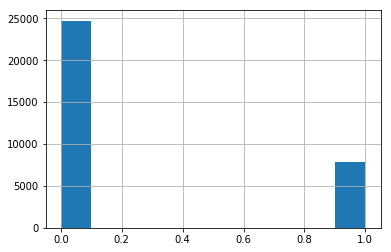

In [9]:
df.Target.hist()

## Validation set
Since we're fitting our model to data, we want to have an unbiased estimate of its performance to help optimise the architecture before we apply the model to the testing data. We can randomly sample a *validation* set from the training data.

In [10]:
_, val_ids = train_test_split(df.index, stratify=df.Target, test_size=0.2, random_state=0)

To help reduce code overhead in the next step, we'll simply set flag in the data for whether or not we want to use each row for training or validation.

In [11]:
df['val'] = 0
df.loc[val_ids, 'val'] = 1

# Feature processing
The data contains both continuous features (real values with numerical comparison) and categorical features (discreet values or string labels with no numerical comparison). Each need to be treated slightly differently.

In [12]:
cat_feats = ['WorkClass', 'Education', 'MaritalStatus', 'Occupation',
             'Relationship', 'Race', 'Gender', 'NativeCountry']
cont_feats = ['Age', 'fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']
train_feats = cont_feats+cat_feats

## Categorical encoding
Our model can only function on numbers, but the categorical features use strings. We can map these string values to integers in order to feed the data into our model. We also want to know whether there are categories which only appear in either training or testing

In [13]:
for feat in ['WorkClass', 'Education', 'MaritalStatus', 'Occupation',
             'Relationship', 'Race', 'Gender', 'NativeCountry']:
    print(feat, set(df[feat]) == set(df_test[feat]))

WorkClass True
Education True
MaritalStatus True
Occupation True
Relationship True
Race True
Gender True
NativeCountry False


In [14]:
print('Missing from test:',  [f for f in set(df.NativeCountry) if f not in set(df_test.NativeCountry)])
print('Missing from train:', [f for f in set(df_test.NativeCountry) if f not in set(df.NativeCountry)])

Missing from test: [' Holand-Netherlands']
Missing from train: []


So, the training data contains an extra country which doesn't appear in the testing data, however the model may well be able to learn things from the extra data which are invarient to country, so we'll keep it in.

We need to ensure the same string --> integer mapping is applied to both training and testing, in order to make sure the data still has the same meaning when we apply the model to the testing data. We'll also construct dictionaries to keep track of the mapping. **N.B.** Pandas has a dedicated column type `Categorical` for helping with this kind of data, but we'll stick with integer mapping for now.

In [15]:
cat_maps = defaultdict(dict)
for feat in ['WorkClass', 'Education', 'MaritalStatus', 'Occupation',
             'Relationship', 'Race', 'Gender', 'NativeCountry']:
    for i, val in enumerate(set(df[feat])):
        cat_maps[feat][val] = i
        df.loc[df[feat] == val, feat] = i
        df_test.loc[df_test[feat] == val, feat] = i

In [16]:
df.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Target,val
0,39,1,77516,2,13,2,7,1,2,1,2174,0,40,41,0,0
1,50,8,83311,2,13,4,11,0,2,1,0,0,13,41,0,0
2,38,6,215646,4,9,1,13,1,2,1,0,0,40,41,0,0
3,53,6,234721,9,7,4,13,0,1,1,0,0,40,41,0,0
4,28,6,338409,2,13,4,6,4,1,0,0,0,40,4,0,0


Looks good, our data now only contains numerical information

## Continuous preprocessing
The weight initialisation we use is optimal for inputs which are unit-Gaussian. The closest we can get is to shift and scale each feature to have mean zero and standard deviation one. `SK-Learn` has `Pipeline` classes to handle series of transformations to data, and we'll use the `StandardScaler` to transform the data.

In [17]:
input_pipe = Pipeline([('norm_in', StandardScaler(with_mean=True, with_std=True))])

Next we need to fit the transformation to the data. Note the Boolean indexing of the data.

In [18]:
input_pipe.fit(df[df.val == 0][cont_feats].values.astype('float32'))

Pipeline(memory=None,
     steps=[('norm_in', StandardScaler(copy=True, with_mean=True, with_std=True))])

And finally apply the transformation to the training, validation, and testing data.

In [19]:
df[cont_feats] = input_pipe.transform(df[cont_feats].values.astype('float32'))
df_test[cont_feats] = input_pipe.transform(df_test[cont_feats].values.astype('float32'))

We can check the transformation by plotting an example feature

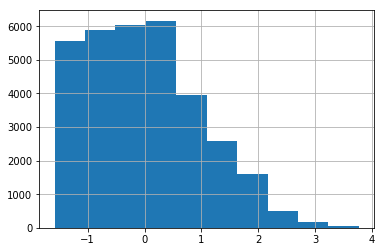

In [20]:
df.Age.hist()

# Model 
Now we need to build a model to fit to the data. Use the previous two example notebooks to help write a function which returns an appropriate model.

In [21]:
def get_model(n_in:int, hidden_sizes:List[int], n_out:int=1, lr:float=1e-3) -> Model:
    model = Sequential()
    for i, w in enumerate(hidden_sizes):
        model.add(Dense(w, input_dim=n_in if i == 0 else None, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(n_out, activation='sigmoid', kernel_initializer='glorot_normal'))

    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

In [22]:
model = get_model(len(train_feats), [100, 100], 1, lr=1e-3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1500      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 11,701
Trainable params: 11,701
Non-trainable params: 0
_________________________________________________________________
None


Now we need to extract out our inputs and targets

In [23]:
x, y = df[df.val == 0][train_feats], df[df.val == 0]['Target']
x_val, y_val = df[df.val == 1][train_feats], df[df.val == 1]['Target']
len(x)

26048

It's also useful to plot the training and validation performance evolution

In [24]:
def plot_history(hist:History) -> None:
    with sns.axes_style('whitegrid'):
        fig, axs = plt.subplots(1, 2, figsize=(24,8))
        axs[0].plot(range(len(hist.history['loss'])), np.array(hist.history['loss']), label='Training')
        axs[0].plot(range(len(hist.history['val_loss'])), np.array(hist.history['val_loss']), label='Validation')
        axs[1].plot(range(len(hist.history['acc'])), np.array(hist.history['acc']), label='Training')
        axs[1].plot(range(len(hist.history['val_acc'])), np.array(hist.history['val_acc']), label='Validation')

        axs[0].set_ylabel("Loss", fontsize=24)
        axs[1].set_ylabel("Accuracy", fontsize=24)
        for ax in axs:
            ax.legend(fontsize=16)
            ax.set_xlabel("Epoch", fontsize=24)
            ax.tick_params(axis='x', labelsize=16)
            ax.tick_params(axis='y', labelsize=16)
        plt.show()

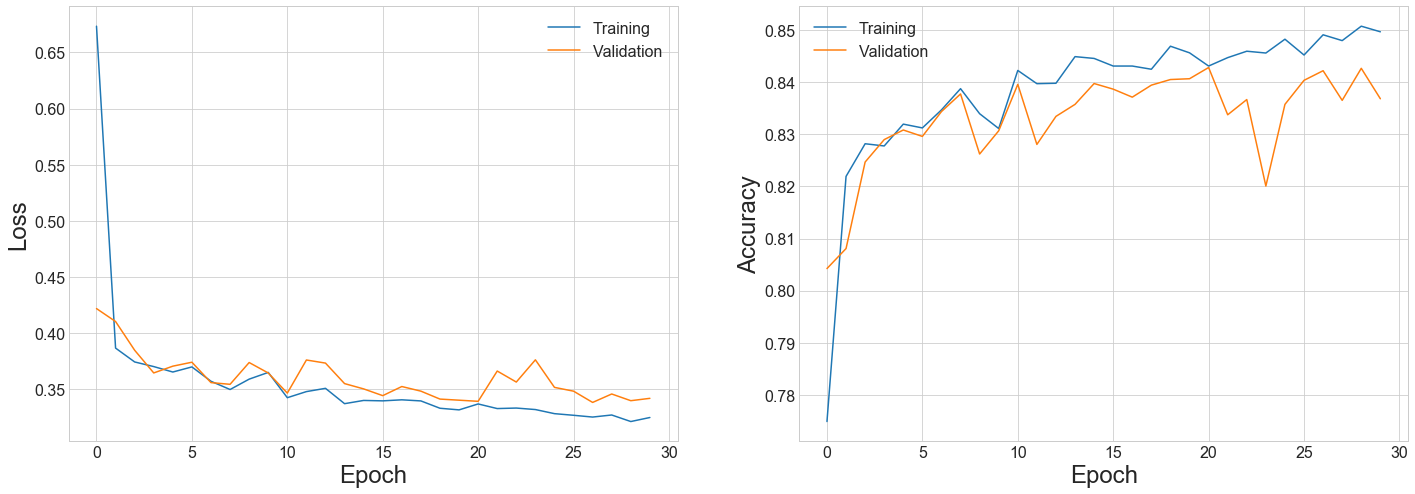

In [25]:
hist = model.fit(x=x, y=y, validation_data=(x_val, y_val), batch_size=128, epochs=30, verbose=0)
plot_history(hist)

# 1-hot encoding
Are treatment of categorical features so far has simply allowed use to feed the inputs into the model, however NNs have a continuous response to inputs and by encoding as integers we have implied a numerical comparison between categories.
An encoding which removes this implication and allows the network to construct separate responses to each category is to expand each feature in to a series of features, one for each category, and mark the correct column with a 1, and the rest as zeros, e.g Monday --> (1,0,0,0,0,0,0)

Pandas has a function to do this.

In [26]:
df = pd.get_dummies(df, columns=cat_feats)
df_test = pd.get_dummies(df_test, columns=cat_feats)

In [27]:
df.head()

,Age,fnlwgt,EducationNum,CapitalGain,CapitalLoss,HoursPerWeek,Target,val,WorkClass_0,WorkClass_1,...,NativeCountry_32,NativeCountry_33,NativeCountry_34,NativeCountry_35,NativeCountry_36,NativeCountry_37,NativeCountry_38,NativeCountry_39,NativeCountry_40,NativeCountry_41
0,0.030732,-1.062885,1.130588,0.143026,-0.212386,-0.032432,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0.837016,-1.007998,1.130588,-0.146647,-0.212386,-2.222496,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.042567,0.245391,-0.414712,-0.146647,-0.212386,-0.032432,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1.056912,0.426057,-1.187362,-0.146647,-0.212386,-0.032432,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-0.775553,1.408121,1.130588,-0.146647,-0.212386,-0.032432,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As we can see, the original categorical columns have been removed and replaced by dedicated columns for each feature category. We do need to remember about the missing category for `NativeCountry` which was not present in testing data, so we can add a column of zeros for that.

In [28]:
cat_maps['NativeCountry'][' Holand-Netherlands']

19

In [29]:
df_test[f"NativeCountry_{cat_maps['NativeCountry'][' Holand-Netherlands']}"] = 0

Note that the number of input features has now shot up from 13 to 108: 1-hot encoding is not an efficient method, but should help our model to better access the information in the data.

In [30]:
cat_feats = [f for f in df.columns if f not in cont_feats+['Target', 'val']]
train_feats = cont_feats+cat_feats
len(train_feats)

108

In [31]:
model = get_model(len(train_feats), [100, 100], 1, lr=1e-3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               10900     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 21,101
Trainable params: 21,101
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
x, y = df[df.val == 0][train_feats], df[df.val == 0]['Target']
x_val, y_val = df[df.val == 1][train_feats], df[df.val == 1]['Target']
len(x)

26048

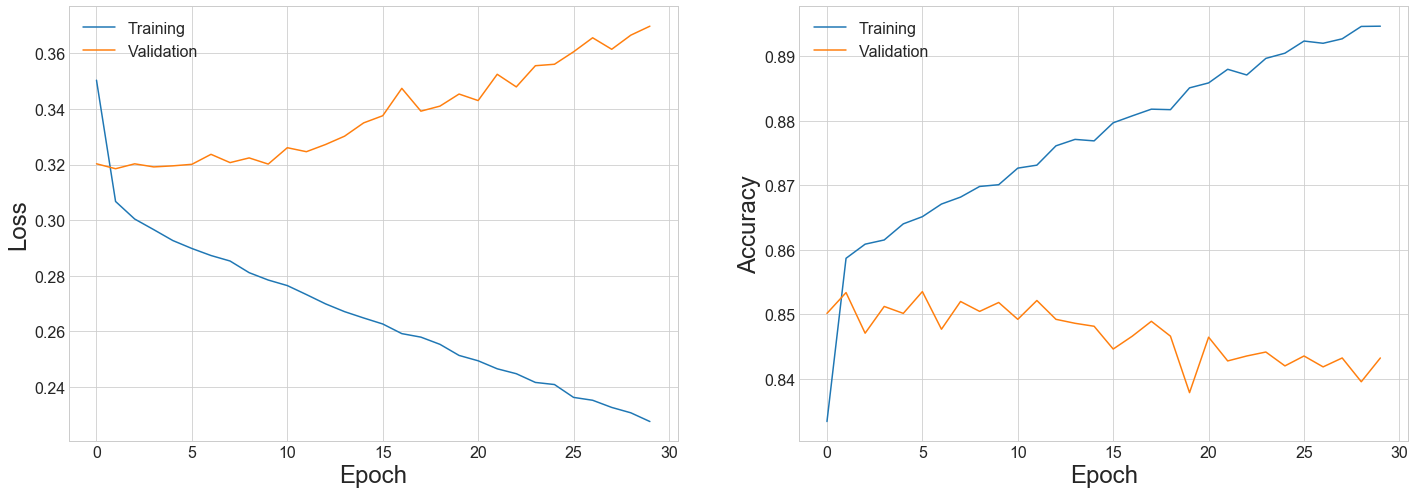

In [33]:
hist = model.fit(x=x, y=y, validation_data=(x_val, y_val), batch_size=128, epochs=30, verbose=0)
plot_history(hist)

## Regularisation
So, whilst the performance of the model improved, we can see overtime that the model begins to overtrain, resulting in a continual decrease in training loss, but this improvement does not transfer to the validation data; the model losses generalisation power.

We can help combat this by applying *regularisation* techniques. One of the most popular is [Dropout](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf).

Adapt you previous model construction function to apply Dropout at a set rate after each dense layer.

In [34]:
def get_do_model(n_in:int, hidden_sizes:List[int], n_out:int=1, lr:float=1e-3, do:float=0) -> Model:
    model = Sequential()
    for i, w in enumerate(hidden_sizes):
        model.add(Dense(w, input_dim=n_in if i == 0 else None, activation='relu', kernel_initializer='he_normal'))
        if do > 0: model.add(Dropout(do))
    model.add(Dense(n_out, activation='sigmoid', kernel_initializer='glorot_normal'))

    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

In [35]:
model = get_do_model(len(train_feats), [100, 100], 1, lr=1e-3, do=0.5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               10900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 21,101
Trainable params: 21,101
Non-trainable params: 0
_________________________________________________________________
None


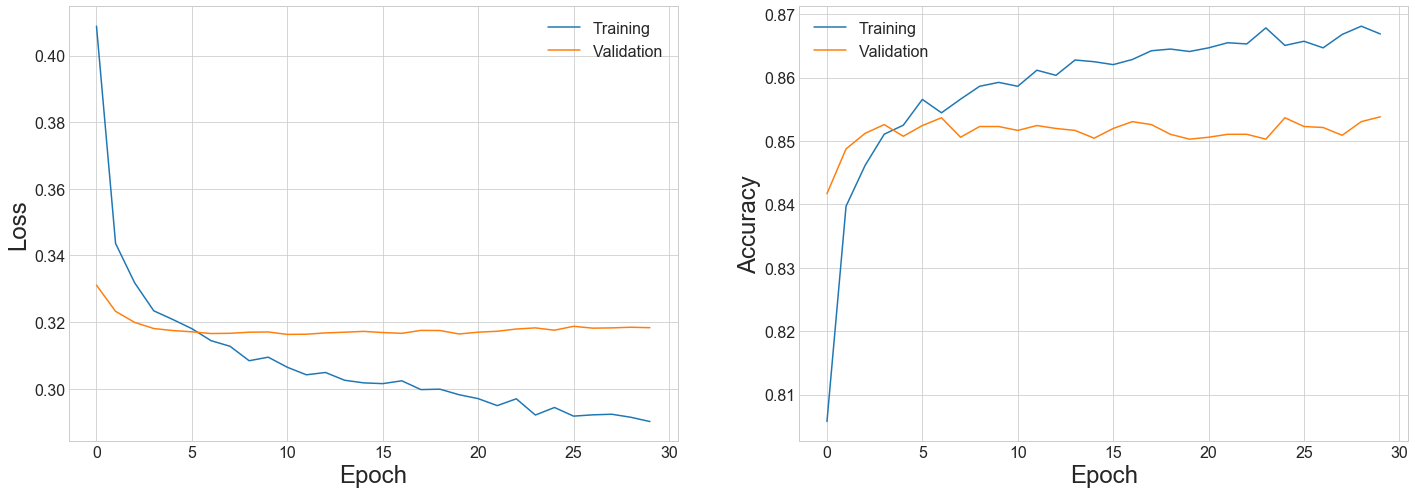

In [36]:
hist = model.fit(x=x, y=y, validation_data=(x_val, y_val), batch_size=128, epochs=30, verbose=0)
plot_history(hist)

Hopefully the model should now still reach about the same validation performance, but the overtraining should now be suppressed.